``Start modelling on metadata again. No imgs only metadata.``

```ONLY one thing: IMPROVE```


# Load data and dependencies

In [1]:
import warnings
import sys
import os
import time
import joblib
import random
from tqdm import tqdm
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from joblib import Parallel, delayed

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, minmax_scale
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

warnings.filterwarnings('ignore')

In [2]:
metadata = pd.read_csv('../data/metadata.csv')
sub_format = pd.read_csv('../data/submission_format.csv')
train_labels = pd.read_csv('../data/train_labels.csv')

# Utils

In [3]:
def rmse(y_true, y_pred):
    return mse(y_true, y_pred, squared=False)

In [4]:
def dens_to_sev(x: float)-> int:
    """takes in density value in cells/ml and returns severity category"""
    if (x < 20_000) : return 1
    elif (x >= 20_000) and (x < 100_000) : return 2
    elif (x >= 100_000) and (x < 1_000_000) : return 3
    elif (x >= 1_000_000) and (x < 10_000_000) : return 4
    elif x > 10_000_000 : return 5

In [5]:
def region_wise_peformance(y_data=None, preds=None):
    """
    returns classifcation report for each region
    y_data : pd.DataFrame
    preds : np.array
    
    """
    y_data = y_data.copy(deep=True)
    y_data['preds'] = preds
    for region in sorted(y_data.region.unique()):
        print(region)
        print(classification_report(y_data[y_data.region == region].severity, y_data[y_data.region == region].preds))
        print()
    

In [67]:
#  Utils
def get_data_by_date( date=None, data=None):
    return data[data.date == date]


def get_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

def analyize_matches(y_true, y_pred, plot=False):
    print("Exact matches: ", sum(y_true == y_pred) / len(y_true))
    print("Missed by 1: ", sum(abs(y_true - y_pred) == 1) / len(y_true))
    print("Missed by 2: ", sum(abs(y_true - y_pred) == 2) / len(y_true))
    print("Missed by 3: ", sum(abs(y_true - y_pred) == 3) / len(y_true))
    print("Missed by 4: ", sum(abs(y_true - y_pred) == 4) / len(y_true))
    
    stupid_vals = []
    for i in range(1, 6):
        stupid_vals.append(
            ((sum([1 for x, y in zip(y_true, y_pred) if x == i and y == i])/len(y_true))*100, (sum(y_true == i)/len(y_true))*100)
            )

    print()
    for i in range(5):
        print(f"Severity {i+1} : accuracy: {np.round(stupid_vals[i][0], 3)} % - prevalence: {np.round(stupid_vals[i][1], 3)} %")
    
    try:
        print()
        print("Classification report:")
        print(classification_report(y_true, y_pred))
    except Exception as e:
        print(e)
        print("Classification report failed")
        
    if plot:
        print()
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Reds')

# Add date fts

In [109]:
metadata.date = pd.to_datetime(metadata.date)
metadata['year'] = metadata.date.dt.year
metadata['month'] = metadata.date.dt.month
metadata['week'] = metadata.date.dt.isocalendar().week

seasons = {
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 2,
    6: 3,
    7: 3,
    8: 3,
    9: 4,
    10: 4,
    11: 4,
    12: 1
}

reg_sev_map = {
    'midwest': 2,
    'northeast': 2,
    'south' : 2,
    'west' : 4
}

reg_map = {
    'south' : 0,
    'northeast' : 1,
    'west' : 2,
    'midwest' : 3
}

metadata['season'] = metadata.month.map(seasons)

region = pd.concat((train_labels, sub_format[['region', 'uid']]), axis=0)

all_data = pd.merge(metadata, region, on='uid', how='left')
all_data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
0,aabm,39.080319,-86.430867,2018-05-14,train,2018,5,20,2,midwest,1.0,585.0
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN
2,aacd,35.875083,-78.878434,2020-11-19,train,2020,11,47,4,south,1.0,290.0
3,aaee,35.487000,-79.062133,2016-08-24,train,2016,8,34,3,south,1.0,1614.0
4,aaff,38.049471,-99.827001,2019-07-23,train,2019,7,30,3,midwest,3.0,111825.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN
23566,zzwo,39.792190,-99.971050,2017-06-19,train,2017,6,25,3,midwest,2.0,48510.0
23567,zzwq,35.794000,-79.012551,2015-03-24,train,2015,3,13,2,south,1.0,1271.0
23568,zzyb,35.742000,-79.238600,2016-11-21,train,2016,11,47,4,south,1.0,9682.0


# CV

In [11]:
def train_eval(model, X_train=None, X_val=None, y_train=None, y_val=None, X_test=None, y_test=None):
    """
    train and eval util func,
    returns trained model, soft_preds, and tr, val, test rmses
    REMEMBER returns soft-preds
    """
    
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    val_rmse = rmse(y_val, np.clip(np.round(val_preds), 1, 5))
    train_rmse = rmse(y_train, np.clip(np.round(model.predict(X_train)), 1, 5))   # don't forget to clip!
    print("Train RMSE: ", train_rmse)
    print("Val RMSE:", val_rmse)
    if X_test is not None and y_test is not None:
        test_rmse = mse(y_test, np.clip(np.round(model.predict(X_test)), 1, 5), squared=False)
        print('TEST RMSE: ', test_rmse)
    else:
        test_rmse = 0
        
    # print("TEST RMSE:", mse(y_val, np.round(model.predict(X_val)), squared=False))
    return model, val_preds, train_rmse, val_rmse, test_rmse

In [12]:

def cv_it(model, X_train=None, y_train=None, X_test=None, y_test=None, splits=10, cv_predict=False):
    """ 
    cv in stratified kfold fashion, 
    returns train, val, test rmses, and cv preds for test and train if cv_predict=True
    remember to round preds
    And also send in "dates" to make val set similar to test set
    """
    
    skf = StratifiedKFold(n_splits=splits, random_state=12_000, shuffle=True)
    # tscv = TimeSeriesSplit(n_splits=splits, test_size=200)
    print('Using cols: ', X_train.columns.values)

    train_rmses = []
    val_rmses = []
    test_rmses = []
    cvpreds_test, cvpreds_train = None, None

    if cv_predict:
        if X_test is not None: test_shape = X_test.shape[0]
        else: test_shape = 6510
        cvpreds_test = np.zeros(shape=(test_shape, splits))
        cvpreds_train = np.zeros(shape=(len(X_train)))

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):

        print(f'----------------------------------Fold-{fold}------------------------------------')
        X_train_subset, y_train_subset = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_subset, y_val_subset = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        try:
            # make val set more similar to test set by making val_set.latlng.isin(trian_set.latlng) --> 0
            X_val_subset['latlng'] = X_val_subset.latitude.astype(str) + '_' + X_val_subset.longitude.astype(str)
            X_train_subset['latlng'] = X_train_subset.latitude.astype(str) + '_' + X_train_subset.longitude.astype(str)

            drp_idx = X_val_subset[X_val_subset.latlng.isin(X_train_subset.latlng)].index
            
            X_train_subset = pd.concat([X_train_subset, X_val_subset.loc[drp_idx]], axis=0)
            y_train_subset = pd.concat([y_train_subset, y_val_subset.loc[drp_idx]], axis=0)

            X_val_subset.drop(drp_idx, inplace=True)
            y_val_subset.drop(drp_idx, inplace=True)
            
            # make sure no latlng is in both train and val_data
            assert X_val_subset.latlng.isin(X_train_subset.latlng).sum() == 0
            
            # drop latlng
            X_val_subset.drop('latlng', axis=1, inplace=True)
            X_train_subset.drop('latlng', axis=1, inplace=True)
        except Exception as e:
            print('Error in making val set more similar to test set')
            print(e)
        
        assert X_train_subset.columns.tolist() == X_val_subset.columns.tolist()
        # assert X_train_subset.columns.tolist() == X_test.columns.tolist()

        print(f'Training on {X_train_subset.shape[0]} samples' )
        print(f'Validating on {X_val_subset.shape[0]} samples' )

        print(y_val_subset.value_counts(normalize=True))
        model, val_preds, train_rmse, val_rmse, test_rmse= train_eval(
                                    model=model, 
                                    X_train=X_train_subset, 
                                    y_train=y_train_subset, 
                                    X_val=X_val_subset, 
                                    y_val=y_val_subset,
                                    X_test=X_test,
                                    y_test=y_test
                                    )

        sns.barplot(model.feature_importances_, model.feature_names_in_)

        val_rmses.append(val_rmse)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        
        if cv_predict:
            # save predictions for ensembling
            if X_test is not None:
                cvpreds_test[:, fold] = model.predict(X_test)
            cvpreds_train[val_idx] = model.predict(X_train.iloc[val_idx])
                    
    print()
    print("Mean Train RMSE:", np.mean(train_rmses), "std:", np.std(train_rmses))
    print("Mean Val RMSE:", np.mean(val_rmses), "std:", np.std(val_rmses))
    print("Mean Test RMSE:", np.mean(test_rmses), "std:", np.std(test_rmses))
    
    return cvpreds_test, cvpreds_train, np.mean(train_rmses), np.mean(val_rmses), np.mean(test_rmses)

# KNN

In [145]:
def knn(row=None, train_data=tr_data, k=1):
    """
    row : pd.Series (row from val_data)
    train_data : pd.DataFrame (all_data)
    k : int number of nearest neighbours to consider
    
    algo:
    1. Get past month data collected till the current row
    2. Get the k nearest neighbours (geodesic dist using lat, lng) from the above data
    3. Get the mean of the severity from the above rows
    4. Return the mean of the nearest neighbours severity

    """
    
    if row is None:
        print('Row None bruv!')
        return None
    
    uid = row.uid
    date = row.date
    region = row.region
    past_date = date - pd.Timedelta(days=30)
    
    past_month_data = train_data[(train_data.date < date) & (train_data.date >= past_date)]
    past_month_data.sort_values(by='date', inplace=True)
    
    # if no past data, return the mean of the region
    if len(past_month_data) == 0:
        return reg_sev_map[region]
        
    dist_matrix =pd.DataFrame(columns=['uid', 'dist'])       # 0th col for uid, 1st col for dist
    for i, past_row in enumerate(past_month_data.itertuples()):
        dist_matrix.loc[i, 'uid'] = past_row.uid
        dist_matrix.loc[i, 'dist'] = get_distance(row.latitude, row.longitude, past_row.latitude, past_row.longitude)   # returns geodesic dist in km

    # get mean of top k nearest neighbours
    n_uids = dist_matrix.sort_values(by='dist').head(k).uid.values
    nn_severity = train_data[train_data.uid.isin(n_uids)].severity.mean()
    
    return np.round(nn_severity)


In [27]:
def knn_wrapper(k=15, train_data=train_data, val_data=val_data):
    sev_list = Parallel(n_jobs=-1, backend='loky')([delayed(knn)(row, train_data=train_data, k=k) for row in val_data.itertuples()])
    return sev_list

# Adding features

## Expanding fts.

In [110]:
data = all_data.sort_values(by='date')
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN


In [111]:
train_data_ = data[data.split == 'train']
train_data_.severity.value_counts(normalize=True)

1.0    0.439449
4.0    0.207913
2.0    0.189859
3.0    0.159379
5.0    0.003400
Name: severity, dtype: float64

In [112]:
grp_by_rm = data.groupby(['region', 'month']).severity.expanding(1).mean()
grp_by_rm = grp_by_rm.map(np.round)
print(grp_by_rm.isna().sum())  
grp_by_rm.fillna(grp_by_rm.groupby('region').transform('mean'), inplace=True)
print(grp_by_rm.isna().sum())  
analyize_matches(train_data_.severity.sort_index(), grp_by_rm.droplevel(0).droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), np.round(grp_by_rm.droplevel(0).droplevel(0).loc[train_data_.index].sort_index()))

# remember rmse is not representative of test set!!
# this is slightly better than the all 1s

72
0
Exact matches:  0.5014067995310668
Missed by 1:  0.44021101992966
Missed by 2:  0.04824150058616647
Missed by 3:  0.009730363423212192
Missed by 4:  0.00041031652989449003

Severity 1 : accuracy: 19.965 % - prevalence: 43.945 %
Severity 2 : accuracy: 12.767 % - prevalence: 18.986 %
Severity 3 : accuracy: 0.545 % - prevalence: 15.938 %
Severity 4 : accuracy: 16.864 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.72      0.45      0.56      7497
         2.0       0.26      0.67      0.37      3239
         3.0       0.18      0.03      0.06      2719
         4.0       0.86      0.81      0.84      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.50     17060
   macro avg       0.40      0.39      0.36     17060
weighted avg       0.57      0.50      0.50     17060



0.8528278592784991

In [113]:
data['exp_grp_by_rm'] = grp_by_rm.droplevel(0).droplevel(0).loc[data.index]
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,exp_grp_by_rm
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0,1.0
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0,1.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0,1.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0,1.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0


In [114]:
grp_by_rs = data.groupby(['region', 'season']).severity.expanding(1).mean()
grp_by_rs = grp_by_rs.map(np.round)
print(grp_by_rs.isna().sum())  
grp_by_rs.fillna(grp_by_rs.groupby('region').transform('mean'), inplace=True)
print(grp_by_rs.isna().sum())  
analyize_matches(train_data_.severity.sort_index(), grp_by_rs.droplevel(0).droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), np.round(grp_by_rs.droplevel(0).droplevel(0).loc[train_data_.index].sort_index()))


5
0
Exact matches:  0.5026377491207503
Missed by 1:  0.4370457209847597
Missed by 2:  0.04882766705744431
Missed by 3:  0.011078546307151231
Missed by 4:  0.00041031652989449003

Severity 1 : accuracy: 19.66 % - prevalence: 43.945 %
Severity 2 : accuracy: 12.749 % - prevalence: 18.986 %
Severity 3 : accuracy: 0.047 % - prevalence: 15.938 %
Severity 4 : accuracy: 17.808 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.71      0.45      0.55      7497
         2.0       0.25      0.67      0.37      3239
         3.0       0.04      0.00      0.01      2719
         4.0       0.85      0.86      0.85      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.50     17060
   macro avg       0.37      0.40      0.36     17060
weighted avg       0.54      0.50      0.49     17060



0.8594349134502333

In [115]:
data['exp_grp_by_rs'] = grp_by_rs.droplevel(0).droplevel(0).loc[data.index]
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,exp_grp_by_rm,exp_grp_by_rs
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0,1.0,1.0
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0,1.0,1.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0,1.0,1.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0,1.0,1.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0,4.0
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0,4.0
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0,4.0
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0,4.0


In [116]:
grp_by_rw = data.groupby(['region', 'week']).severity.expanding(1).mean()
grp_by_rw = grp_by_rw.map(np.round)
print(grp_by_rw.isna().sum())  
grp_by_rw.fillna(grp_by_rw.groupby('region').transform('mean'), inplace=True)
print(grp_by_rw.isna().sum())  
analyize_matches(train_data_.severity.sort_index(), grp_by_rw.droplevel(0).droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), np.round(grp_by_rw.droplevel(0).droplevel(0).loc[train_data_.index].sort_index()))


566
0
Exact matches:  0.5229191090269637
Missed by 1:  0.4243259085580305
Missed by 2:  0.045603751465416176
Missed by 3:  0.006740914419695193
Missed by 4:  0.00041031652989449003

Severity 1 : accuracy: 20.41 % - prevalence: 43.945 %
Severity 2 : accuracy: 12.737 % - prevalence: 18.986 %
Severity 3 : accuracy: 2.227 % - prevalence: 15.938 %
Severity 4 : accuracy: 16.911 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.006 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.74      0.46      0.57      7497
         2.0       0.27      0.67      0.38      3239
         3.0       0.37      0.14      0.20      2719
         4.0       0.89      0.81      0.85      3547
         5.0       1.00      0.02      0.03        58

    accuracy                           0.52     17060
   macro avg       0.65      0.42      0.41     17060
weighted avg       0.62      0.52      0.53     17060



0.8209593221806205

In [117]:
data['exp_grp_by_rw'] = grp_by_rw.droplevel(0).droplevel(0).loc[data.index]
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,exp_grp_by_rm,exp_grp_by_rs,exp_grp_by_rw
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0,1.0,1.0,1.0
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0,1.0,1.0,1.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0,1.0,1.0,1.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0,1.0,1.0,1.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0,4.0,4.0
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0,4.0,4.0
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0,4.0,4.0
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0,4.0,4.0


In [118]:
data[data.columns[data.columns.str.startswith('exp')]].corr()
# wonder if these are useful!

,exp_grp_by_rm,exp_grp_by_rs,exp_grp_by_rw
exp_grp_by_rm,1.000000,0.955841,0.897347
exp_grp_by_rs,0.955841,1.000000,0.890837
exp_grp_by_rw,0.897347,0.890837,1.000000


## Rolling fts.

In [ ]:
# best rolling window is 7 days

In [151]:
data.groupby('region').severity.rolling(7, min_periods=1).mean().map(np.round).fillna(data.groupby('region').severity.transform('mean')).isna().sum()

1534

# Split

In [135]:
test_data = data[data.split == 'test']
test_data.shape, data.shape

((6510, 15), (23570, 15))

In [136]:
train_data = data[data.split == 'train']
train_data.shape, data.shape

((17060, 15), (23570, 15))

In [137]:
tr_data, val_data = train_test_split(train_data, test_size=0.15, random_state=123456789, shuffle=True)
tr_data.shape, val_data.shape

((14501, 15), (2559, 15))

In [138]:
X_test = test_data[train_data.columns]
X_test

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,exp_grp_by_rm,exp_grp_by_rs,exp_grp_by_rw
3661,eamn,36.9818,-120.221,2013-01-08,test,2013,1,2,1,west,NaN,NaN,3.897829,3.952559,3.791702
6865,howw,37.0062,-120.600,2013-01-08,test,2013,1,2,1,west,NaN,NaN,4.000000,4.000000,4.000000
7668,imsv,36.9836,-120.500,2013-01-08,test,2013,1,2,1,west,NaN,NaN,4.000000,4.000000,4.000000
16095,rsos,33.8892,-117.562,2013-01-25,test,2013,1,4,1,west,NaN,NaN,4.000000,4.000000,4.000000
20182,wgxq,33.8011,-117.205,2013-01-25,test,2013,1,4,1,west,NaN,NaN,4.000000,4.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.7368,-121.734,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.000000,4.000000,4.000000
17559,thki,36.7254,-121.730,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.000000,4.000000,4.000000
17452,teuu,36.7723,-121.788,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.000000,4.000000,4.000000
14254,prfi,36.7518,-121.742,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.000000,4.000000,4.000000


# Train 

In [139]:
tr_data.columns

Index(['uid', 'latitude', 'longitude', 'date', 'split', 'year', 'month',
       'week', 'season', 'region', 'severity', 'density', 'exp_grp_by_rm',
       'exp_grp_by_rs', 'exp_grp_by_rw'],
      dtype='object')

In [161]:
drop_cols = ['date', 'uid', 'severity', 'year', 'split', 'density',]
drop_cols

['date', 'uid', 'severity', 'year', 'split', 'density']

In [162]:
X_train = tr_data.drop(columns=drop_cols)
X_train.week = X_train.week.astype('int')
X_train.region = X_train.region.map(reg_map)  # reg map is better than reg_sev_map
y_train = tr_data.severity

X_val = val_data.drop(columns=drop_cols)
X_val.week = X_val.week.astype('int')
X_val.region = X_val.region.map(reg_map)
y_val = val_data.severity

In [163]:
assert X_train.columns.to_list() == X_val.columns.to_list()
assert y_train.index.to_list() == X_train.index.to_list()
assert y_val.index.to_list() == X_val.index.to_list()

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=0,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, predictor=None, random_state=12000,
             reg_alpha=None, reg_lambda=None, ...)
Using cols:  ['latitude' 'longitude' 'month' 'week' 'season' 'region' 'exp_grp_by_rm'
 'exp_grp_by_rs' 'exp_grp_by_rw']
----------------------------------Fold-0------------------------------------
Training on 13636 samples
Validating on 865 samples
1.0    0.588439
2.0    0.243

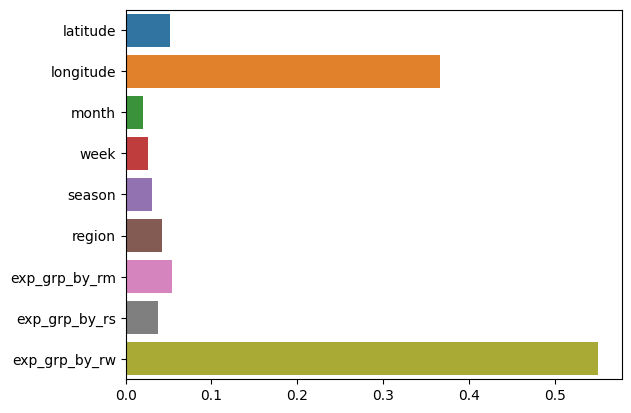

In [164]:
xgb = XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=12_000, tree_method='gpu_hist', gpu_id=0)
print(xgb)

te_preds, tr_preds ,*_= cv_it(model=xgb, X_train=X_train, y_train=y_train, X_test=X_val, y_test=y_val, splits=10, cv_predict=True)

In [165]:
analyize_matches(y_val, np.clip(np.round(np.mean(te_preds, axis=1)), 1, 5))

analyize_matches(y_train, np.clip(np.round(tr_preds), 1, 5))

Exact matches:  0.6463462289957015
Missed by 1:  0.3173114497850723
Missed by 2:  0.03399765533411489
Missed by 3:  0.0015631105900742479
Missed by 4:  0.0007815552950371239

Severity 1 : accuracy: 30.012 % - prevalence: 44.314 %
Severity 2 : accuracy: 10.668 % - prevalence: 19.031 %
Severity 3 : accuracy: 5.119 % - prevalence: 15.279 %
Severity 4 : accuracy: 18.835 % - prevalence: 20.789 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.586 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.79      0.68      0.73      1134
         2.0       0.34      0.56      0.42       487
         3.0       0.53      0.34      0.41       391
         4.0       0.92      0.91      0.91       532
         5.0       0.00      0.00      0.00        15

    accuracy                           0.65      2559
   macro avg       0.51      0.50      0.49      2559
weighted avg       0.69      0.65      0.66      2559

Exact matches:  0.6751258533894214
Missed 

In [166]:
region_wise_peformance(y_data=tr_data, preds=np.clip(np.round(tr_preds), 1, 5))

region_wise_peformance(y_data=val_data, preds=np.clip(np.round(np.mean(te_preds, axis=1)), 1, 5))

midwest
              precision    recall  f1-score   support

         1.0       0.96      0.75      0.84       667
         2.0       0.44      0.68      0.54       359
         3.0       0.68      0.75      0.72       652
         4.0       0.68      0.28      0.39       167
         5.0       1.00      0.10      0.18        10

    accuracy                           0.69      1855
   macro avg       0.75      0.51      0.53      1855
weighted avg       0.74      0.69      0.69      1855


northeast
              precision    recall  f1-score   support

         1.0       0.94      0.75      0.84       466
         2.0       0.55      0.84      0.67       279
         3.0       0.60      0.52      0.56       181
         4.0       0.50      0.24      0.32        38
         5.0       1.00      0.27      0.43        11

    accuracy                           0.71       975
   macro avg       0.72      0.52      0.56       975
weighted avg       0.75      0.71      0.71       975


so

# Test Predictions

In [167]:
X_train.columns.to_list() == X_val.columns.to_list()

True

In [168]:
X_test = X_test[X_train.columns]
assert X_test.columns.tolist() == X_train.columns.tolist()

X_test

,latitude,longitude,month,week,season,region,exp_grp_by_rm,exp_grp_by_rs,exp_grp_by_rw
3661,36.9818,-120.221,1,2,1,west,3.897829,3.952559,3.791702
6865,37.0062,-120.600,1,2,1,west,4.000000,4.000000,4.000000
7668,36.9836,-120.500,1,2,1,west,4.000000,4.000000,4.000000
16095,33.8892,-117.562,1,4,1,west,4.000000,4.000000,4.000000
20182,33.8011,-117.205,1,4,1,west,4.000000,4.000000,4.000000
...,...,...,...,...,...,...,...,...,...
12443,36.7368,-121.734,12,52,1,west,4.000000,4.000000,4.000000
17559,36.7254,-121.730,12,52,1,west,4.000000,4.000000,4.000000
17452,36.7723,-121.788,12,52,1,west,4.000000,4.000000,4.000000
14254,36.7518,-121.742,12,52,1,west,4.000000,4.000000,4.000000


In [169]:
all_X_train = pd.concat([X_train, X_val], axis=0)
all_y_train = pd.concat([y_train, y_val], axis=0)

assert all_X_train.shape[0] == all_y_train.shape[0]
assert all_X_train.columns.tolist() == X_test.columns.tolist()

all_X_train.shape, all_y_train.shape

((17060, 9), (17060,))

In [170]:
X_test.week = X_test.week.astype('int')
X_test.region = X_test.region.map(reg_map)

Using cols:  ['latitude' 'longitude' 'month' 'week' 'season' 'region' 'exp_grp_by_rm'
 'exp_grp_by_rs' 'exp_grp_by_rw']
----------------------------------Fold-0------------------------------------
Training on 16011 samples
Validating on 1049 samples
1.0    0.576740
2.0    0.241182
3.0    0.146806
4.0    0.034318
5.0    0.000953
Name: severity, dtype: float64
Train RMSE:  0.6435955461556706
Val RMSE: 0.750595569060738
----------------------------------Fold-1------------------------------------
Training on 16068 samples
Validating on 992 samples
1.0    0.589718
2.0    0.242944
3.0    0.137097
4.0    0.026210
5.0    0.004032
Name: severity, dtype: float64
Train RMSE:  0.6446771774938823
Val RMSE: 0.7526833717204839
----------------------------------Fold-2------------------------------------
Training on 16040 samples
Validating on 1020 samples
1.0    0.592157
2.0    0.230392
3.0    0.145098
4.0    0.028431
5.0    0.003922
Name: severity, dtype: float64
Train RMSE:  0.6417518106976137
Val R

(6510, 10)

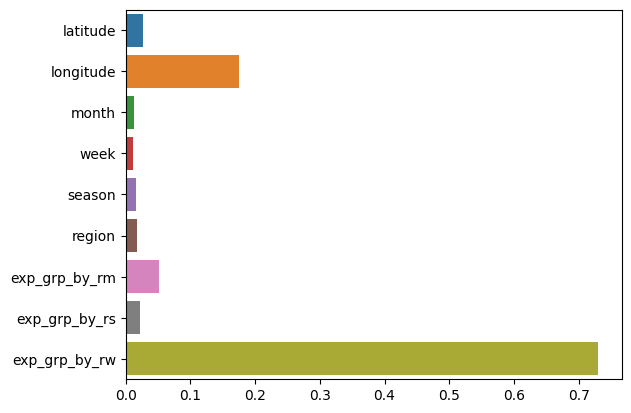

In [172]:
xgb_reg = XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.1, n_jobs=-1, random_state=12_000, tree_method='gpu_hist', gpu_id=0)
test_preds_cv, train_preds_cv,  *_= cv_it(xgb_reg, all_X_train, all_y_train, X_test=X_test, splits=10, cv_predict=True)
test_preds_cv.shape

In [173]:
preds_rmr = np.round(np.mean(np.round(test_preds_cv), axis=1)) # mean of rounded predictions
preds_rm = np.round(np.mean(test_preds_cv, axis=1))  # rounded mean

In [176]:
np.mean(preds_rm), np.std(preds_rm), np.mean(preds_rmr), np.std(preds_rmr)

(2.4829493087557606, 1.0754634890708317, 2.480184331797235, 1.0819666751544044)

In [177]:
analyize_matches(preds_rmr, preds_rm)

Exact matches:  0.9566820276497696
Missed by 1:  0.04331797235023042
Missed by 2:  0.0
Missed by 3:  0.0
Missed by 4:  0.0

Severity 1 : accuracy: 19.462 % - prevalence: 19.892 %
Severity 2 : accuracy: 34.316 % - prevalence: 36.713 %
Severity 3 : accuracy: 18.909 % - prevalence: 19.293 %
Severity 4 : accuracy: 21.997 % - prevalence: 23.072 %
Severity 5 : accuracy: 0.891 % - prevalence: 0.906 %

Classification report:
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86         8
         1.0       0.96      0.98      0.97      1295
         2.0       0.98      0.93      0.96      2390
         3.0       0.87      0.98      0.92      1256
         4.0       0.99      0.95      0.97      1502
         5.0       1.00      0.98      0.99        59

    accuracy                           0.96      6510
   macro avg       0.97      0.93      0.95      6510
weighted avg       0.96      0.96      0.96      6510



## Submission

In [ ]:
# make submissions

sub_format.severity = preds_rmr.astype('int')
sub_format.to_csv('../submissions/to submit/xgb_1k_exp_rwrsrm_cv_preds_rmr.csv', index=False)

sub_format.severity = preds_rm.astype('int')
sub_format.to_csv('../submissions/to submit/xgb_1k_exp_rwrsrm_cv_preds_rm.csv', index=False)